In this file, we will write the code that basically tests our model as required by the submission<br>
1. Write code to get all the images from the test folder --> (here we have assumed Val to be the test folder)
2. Reconstruct those images, these reconstructed images should be stored in a folder
3. Report PSNR, SSIM on an individual object level as well as on the entire datset

## Necessary Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn.init as init
import torch.nn.functional as F

In [3]:
import os
from PIL import Image

In [4]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Fetching our data

`the function below is responsible for getting all the image paths for the test (Val in this case) data`

In [134]:
def get_image_path(root, folder="Train", type="Degraded_image" ): #returns paths of all the images from the given folder
#  root=root+"/drive/MyDrive" #this line is for google colab
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
#  print("zeroeth print statement")
 print(os.listdir(dataset_path))
 image_paths=[]
#go inside each of the object directories, for each of them
#go inside Train folder,
#inside train, go inside gthe Degraded_image directory,
#inside Degraded_image directory, there are different directories,
#inside each of these directories there are images that we have to extract, which are basically our noised image
 for object in sorted(os.listdir(dataset_path)):
    object_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object)
    # print("First print statement")
    # print(os.listdir(object_directory_path))


    for train_folder in sorted(os.listdir(object_directory_path)):
      if(train_folder==folder):
        train_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object, train_folder)
        # print("second print staement")
        # print(os.listdir(train_directory_path))

        for degraded_image_folder in os.listdir(train_directory_path):
            if(degraded_image_folder==type):

                image_folder_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder))
                # print("third print statement")
                # print(image_folder_path)
                # return []
                for image_folder in sorted(image_folder_path):
                    #inside each image folder, get the images and store them in images list
                    # print(image_folder_path)
                    image_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder))
                    # print("fourth print statement")
                    # image_path.sort()
                    # print(image_path)
                    # return []
                    for image in sorted(image_path):
                        #now we need to store these images in a list so that they can be accessed later
                        image_paths.append(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder, image))
 return image_paths

In [135]:
degraded_test_image_paths=get_image_path(os.getcwd(), folder="Val", #folder="Test" for the test data 
                                    type="Degraded_image")

clean_test_image_paths=get_image_path(os.getcwd(), 
                                 folder="Val", 
                                 type="GT_clean_image")

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [136]:
defect_masks_paths=get_image_path(os.getcwd(),  #this contains the defect masks, we will use this to test psnr and ssim on the test data
                                        folder="Val", 
                                        type="Defect_mask")

['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']


In [137]:
len(clean_test_image_paths), len(degraded_test_image_paths), len(defect_masks_paths)

(88, 88, 88)

## DataSet and DataLoader Objects

`we have the image paths, the next task is to define a dataloader object which we can then use to pass images to our model`

In [138]:
def convert_gray_to_rgb(image):
    # Check if input is a numpy array
    if isinstance(image, np.ndarray):
        # If already RGB (3 channels), return as is
        if image.ndim == 3 and image.shape[-1] == 3:
            return image
        # Otherwise, convert grayscale to RGB
        return np.stack([image] * 3, axis=-1)

    # For PIL Images, check if already RGB
    if image.mode == 'RGB':
        return image
    # Convert grayscale to RGB
    return Image.merge('RGB', [image] * 3)


def resize(image):
    # Assuming you want to resize to 256x256 - adjust size if needed
    if isinstance(image, np.ndarray):
        return Image.fromarray(image).resize((256, 256), Image.Resampling.BILINEAR)
    return image.resize((256, 256), Image.Resampling.BILINEAR)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(convert_gray_to_rgb),
    transforms.Lambda(resize),
    transforms.ToTensor(),
])

class SimpleDataset(Dataset):
    def __init__(self, noisy_paths, clean_paths, transform=transform):
        self.noisy_paths = noisy_paths
        self.clean_paths = clean_paths
        self.transform = transform

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_paths[idx])
        clean_image = Image.open(self.clean_paths[idx])

        noisy_tensor = self.transform(noisy_image)
        clean_tensor = self.transform(clean_image)

        return noisy_tensor, clean_tensor


In [139]:
test_dataset=SimpleDataset(degraded_test_image_paths, clean_test_image_paths)
test_dataloader=DataLoader(dataset=test_dataset, batch_size=1, shuffle=False) #smaller batch size as data is less and also won't need to move it to gpu

In [140]:
len(test_dataloader)

88

## Loading our trained model

#### Model defination and Architecture

In [141]:
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        denoised_output = y - out
        return torch.clamp(denoised_output, 0, 1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

#### Model Initialisation and loading

In [142]:
model2=DnCNN(depth=17, n_channels=64,image_channels=3).to(device)
# loss_fn=nn.MSELoss()
# optimizer=torch.optim.Adam(model2.parameters(), lr=0.0001)

init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight
init weight


In [143]:
#loading our model
#regardless of whether we have a gpu or not, this will load the model on the cpu
model2.load_state_dict(torch.load("DnCNN_model_520_epochs_augmenteted.pth", map_location=torch.device('cpu')))

C:\Users\abhig\AppData\Local\Temp\ipykernel_20388\1860771308.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("DnCNN_model_520_epochs_au

<All keys matched successfully>

## Doing the Tasks Specified in the mail one by one

#### `For each of the test images, your model should give output images and should be saved in an output folder. Average PSNR and SSIM values for each object as well as for the whole test set should be printed or saved in a file`

#### Saving the Reconstructed test images to a folder named Reconstucted_images.

In [144]:
import os
#create the folder if not already present
if not os.path.exists('Reconstructed_images'):
    os.makedirs('Reconstructed_images')

In [145]:
def save_image(image, name):
    #give a passed image, stored them into the folder: Reconstructd_images

    #PIL expects the image to be in the range 0-255
    image = ((image - image.min()) * 255 / (image.max() - image.min())).clip(0, 255).astype(np.uint8)
    
    Image.fromarray(image).save(f'Reconstructed_images/{name}.png')

`The cell below will store all the reconstructed versions of the images into the folder Reconstructed_images`

In [146]:
model2.eval()
with torch.inference_mode():

    for i, (noisy, clean) in enumerate(test_dataloader):
        noisy=noisy.to(device)
        clean=clean.to(device)
        reconstructed=model2(noisy)
        #we need to save this reconstructed image somewhere
        reconstructed=reconstructed.cpu().numpy() 
        reconstructed=reconstructed[0].transpose(1, 2, 0)  #converting the image to HxWxC format
        save_image(reconstructed, i)
        if(i==10): break

### PSNR for the entire dataset as well for for inidividual objects

#### For the entire test data

In [147]:
def psnr(img1, img2, max_pixel_value=1.0): #this will give us the psnr value per image for a given batch, we'll have to eventually divide the outcome by total no. of batches
    mse = F.mse_loss(img1, img2)
    psnr_value = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr_value

In [148]:
model2.eval()
with torch.inference_mode():
    total_loss = 0
    for noisy, clean in test_dataloader:
        noisy, clean = noisy.to(device), clean.to(device)
        reconstructed = model2(noisy)

        # PSNR calculation for images in range [0,1]
        loss = psnr(reconstructed, clean, 1.0)  # Note max_pixel=1.0
        total_loss += loss #this is being added for each image because batch size if 1

print(f"Average PSNR for the entire validation set: {(total_loss)/len(test_dataloader):.2f} dB")

Average PSNR for the entire validation set: 30.09 dB


#### PSNR for Individual Objects of the test data

##### Necessary Helper Functions that will arrange everything properly like getting the images associated with a given object, etc.

In [149]:
def get_object_names(root): #returns the names of all the different objects that we have
#  root=root+"/drive/MyDrive" #this line is in case you have mounted the google drive on your notebook and it contains the dataset
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
 object_names=[]

 for object in sorted(os.listdir(dataset_path)):
  object_names.append(object)

 return object_names

In [150]:
objects=get_object_names(os.getcwd())
objects

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

given an object's name, the function below returns paths of the images, that belong to that object in the specified folder (Val folder for our case)

In [151]:
def get_paths_of_an_object(root, object_name, folder="Val", type="Degraded_image" ): #returns paths of all the images of a given object
#  root=root+"/drive/MyDrive"  #this line is if you are running in colab and the drive is mounted on the notebook
 dataset_path=os.path.join(root, "Denoising_Dataset_train_val")
 image_paths=[]

 for object in sorted(os.listdir(dataset_path)):
  if object==object_name:
    object_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object)
    # print("First print statement")
    # print(os.listdir(object_directory_path))


    for train_folder in sorted(os.listdir(object_directory_path)):
      if(train_folder==folder): #validation folder
        train_directory_path=os.path.join(root, "Denoising_Dataset_train_val", object, train_folder)
        # print("second print staement")
        # print(os.listdir(train_directory_path))

        for degraded_image_folder in os.listdir(train_directory_path):
            if(degraded_image_folder==type):

                image_folder_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder))
                # print("third print statement")
                # print(image_folder_path)
                # return []
                for image_folder in sorted(image_folder_path):
                    #inside each image folder, get the images and store them in images list
                    # print(image_folder_path)
                    image_path=os.listdir(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder))
                    # print("fourth print statement")
                    # image_path.sort()
                    # print(image_path)
                    # return []
                    for image in sorted(image_path):
                        #now we need to store these images in a list so that they can be accessed later
                        image_paths.append(os.path.join(root, "Denoising_Dataset_train_val", object, train_folder, degraded_image_folder, image_folder, image))
 return image_paths

#### PSNR Score for each object

In [152]:
psnr_scores=[]

In [153]:
model2.eval()
with torch.inference_mode():

    for object in objects:
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object)
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")

        #first we must load the images and then apply appropriate transformations before passing the degraded images to the model
        #finally we can calculate the psnr

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 256, 256)
        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same thing for clean_images
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 256, 256)
        # print("clean images length is ", len(clean_images))
        for i, image in enumerate(clean_object_image_paths):
          # print('i is ', i)
          pil_image=Image.open(image)
          image=transform(pil_image)
          clean_images[i]=image

        reconstructed_images=model2(degraded_images.to(device))
        psnr_score=psnr(reconstructed_images, clean_images.to(device)).item()
        psnr_scores.append(psnr_score)
        print(f"psnr for {object} is ", psnr_score)

psnr for bottle is  27.90460205078125
psnr for cable is  28.174922943115234
psnr for capsule is  32.44432830810547
psnr for carpet is  24.79984474182129
psnr for grid is  27.593223571777344
psnr for hazelnut is  32.60150146484375
psnr for leather is  29.886417388916016
psnr for metal_nut is  29.52081871032715
psnr for pill is  32.56135177612305
psnr for screw is  31.90734100341797
psnr for tile is  25.922489166259766
psnr for toothbrush is  31.654462814331055
psnr for transistor is  30.82946014404297
psnr for wood is  28.21922492980957
psnr for zipper is  31.065874099731445


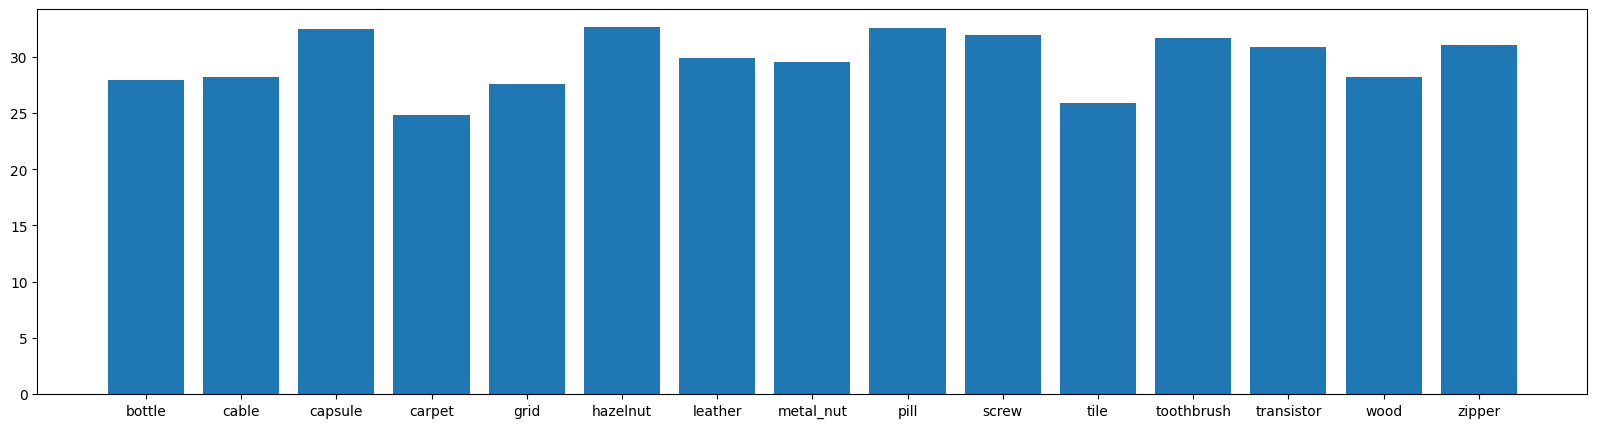

In [154]:
plt.figure(figsize=(20, 5))
plt.bar(objects, psnr_scores)
plt.show()

### SSIM for the entire dataset as well for for inidividual objects

#### SSIM for individual Objects

In [155]:
#if using colab --> use these inbuilt methods and replace compute_ssim with ssim in cell 51
# from skimage import io
# from skimage.metrics import structural_similarity as ssim

In [156]:
import cv2

In [157]:
def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Images should be in same size and in numpy array format.
    """
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    
    # Convert to float
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    
    # Compute means
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    
    # Compute variances and covariance
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    
    # Calculate SSIM
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    
    return ssim_map.mean()

# Example usage:
def compute_ssim(img1, img2):
    """
    Wrapper function to handle different input types and color channels
    """
    # If images are PyTorch tensors, convert to numpy
    if torch.is_tensor(img1):
        img1 = img1.cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.cpu().numpy()
    
    # If images are in range [0,1], convert to [0,255]
    if img1.max() <= 1.0:
        img1 = (img1 * 255).astype(np.uint8)
    if img2.max() <= 1.0:
        img2 = (img2 * 255).astype(np.uint8)
    
    # Convert to uint8 if not already
    img1 = img1.astype(np.uint8)
    img2 = img2.astype(np.uint8)
    
    # Handle RGB images
    if len(img1.shape) == 3:
        # Calculate SSIM for each channel and take mean
        ssim_score = np.mean([calculate_ssim(img1[..., i], img2[..., i]) 
                            for i in range(img1.shape[-1])])
    else:
        ssim_score = calculate_ssim(img1, img2)
        
    return ssim_score

# Usage:
# ssim = compute_ssim(image1, image2)
# print(f"SSIM Score: {ssim}")

In [158]:
individual_objects_ssim_scores=[]

In [159]:
model2.eval()
with torch.inference_mode():

    for object in objects:
        ssim_scores=[] #stores the ssim for each image and then finally we can compute the mean from this
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val")
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")

        #first we must load the images and then apply appropriate transformations before passing the degraded images to the model
        #finally we can calculate the psnr

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 256, 256)
        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same thing for clean_images
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 256, 256)
        # print("clean images length is ", len(clean_images))
        for i, image in enumerate(clean_object_image_paths):
          # print('i is ', i)
          pil_image=Image.open(image)
          image=transform(pil_image)
          clean_images[i]=image

        reconstructed_images=model2(degraded_images.to(device))

        #until here, we have the clean images and the reconstructed ones
        #now we need to compute the ssim individually, however keep in mind that the function ssim expects images like HxWxChannels
        for i, image in enumerate(reconstructed_images):
           reconstructed_np_image=image.cpu().numpy()
           clean_np_image=clean_images[i].cpu().numpy()

           ssim_score=compute_ssim(reconstructed_np_image.transpose(1, 2, 0),  clean_np_image.transpose(1, 2, 0))

           ssim_scores.append(ssim_score)
        individual_objects_ssim_scores.append(np.mean(ssim_scores))
        print(f"ssim_score for {object} is ", np.mean(ssim_scores))


ssim_score for bottle is  0.8812582946679322
ssim_score for cable is  0.8588993197379602
ssim_score for capsule is  0.9350646441388001
ssim_score for carpet is  0.8275515852143496
ssim_score for grid is  0.8701511955071032
ssim_score for hazelnut is  0.9218877424264518
ssim_score for leather is  0.6777142871642298
ssim_score for metal_nut is  0.8176070752295294
ssim_score for pill is  0.916495905593118
ssim_score for screw is  0.9305753075193738
ssim_score for tile is  0.749390097356638
ssim_score for toothbrush is  0.9038324198649555
ssim_score for transistor is  0.9143779047362376
ssim_score for wood is  0.6980937784689301
ssim_score for zipper is  0.7558662943304375


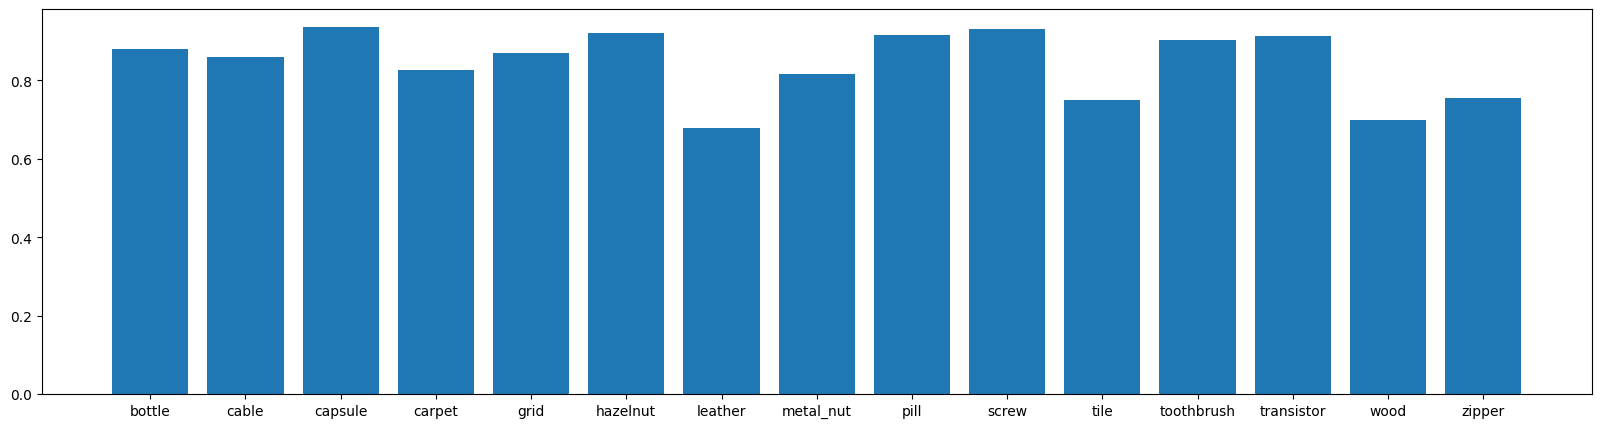

In [160]:
plt.figure(figsize=(20, 5))
plt.bar(objects, individual_objects_ssim_scores)
plt.show()

#### For the entire test data

In [161]:
print("Average SSIM for the test set is ", np.mean(individual_objects_ssim_scores))

Average SSIM for the test set is  0.8439177234637365


`first we get the reconstructed_images, then multiply (broadcast them by the defect mask image) This will ensure that only the defected area is left for the reconsturcted image, next we can calculate the psnrr and ssim on these images`

### PSNR For defect masks

we first reconstruct the noisy images and then what we do is, we only retain the portion of the images that is given in the defect mask: for both the reconstructed and clean images, then we find psnr on these 2 images

In [164]:
psnr_scores_defect_mask=[]
model2.eval()
with torch.inference_mode():

    for object in objects:
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object)
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")
        defect_mask_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "Defect_mask")
        #first we must load the images and then apply appropriate transformations before passing the degraded images to the model
        #finally we can calculate the psnr

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 256, 256)
        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same thing for clean_images
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 256, 256)
        # print("clean images length is ", len(clean_images))
        for i, image in enumerate(clean_object_image_paths):
          # print('i is ', i)
          pil_image=Image.open(image)
          image=transform(pil_image)
          clean_images[i]=image
        
        reconstructed_images=model2(degraded_images.to(device))

        defect_mask_images=torch.zeros(len(defect_mask_object_image_paths), 3, 256, 256)
        for i, image in enumerate(defect_mask_object_image_paths):
            pil_image=Image.open(image)
            defect_mask=transform(pil_image)
            defect_mask_images[i]=defect_mask
        #since we now have the reconstructed_images as well as the clean ones, 
        #we can apply the defect mask on each of these
        defect_mask_applied_reconstructed= torch.zeros(len(reconstructed_images), 3, 256, 256).to(device) #because reconstructed_images will be on the device since they are returned by the model
        defect_mask_applied_clean=torch.zeros(len(clean_images), 3, 256, 256)
        for i in range(len(reconstructed_images)):
            #multiply the reconstructed and clean images with the defect mask images, and then calculate the psnr
            defect_mask_applied_reconstructed[i]=defect_mask_images[i]*reconstructed_images[i]

            defect_mask_applied_clean[i]=defect_mask_images[i]* clean_images[i]
        
        psnr_score=psnr(defect_mask_applied_reconstructed, defect_mask_applied_clean.to(device)).item()
        psnr_scores_defect_mask.append(psnr_score)
        print(f"psnr for defect mask for {object} is ", psnr_score)

psnr for defect mask for bottle is  39.08306884765625
psnr for defect mask for cable is  39.93761444091797
psnr for defect mask for capsule is  53.01537322998047
psnr for defect mask for carpet is  39.90264892578125
psnr for defect mask for grid is  44.84999084472656
psnr for defect mask for hazelnut is  37.37675476074219
psnr for defect mask for leather is  46.92424774169922
psnr for defect mask for metal_nut is  42.21202087402344
psnr for defect mask for pill is  39.00896453857422
psnr for defect mask for screw is  52.21516036987305
psnr for defect mask for tile is  35.289833068847656
psnr for defect mask for toothbrush is  43.20071792602539
psnr for defect mask for transistor is  38.14266586303711
psnr for defect mask for wood is  42.55637741088867
psnr for defect mask for zipper is  43.532432556152344


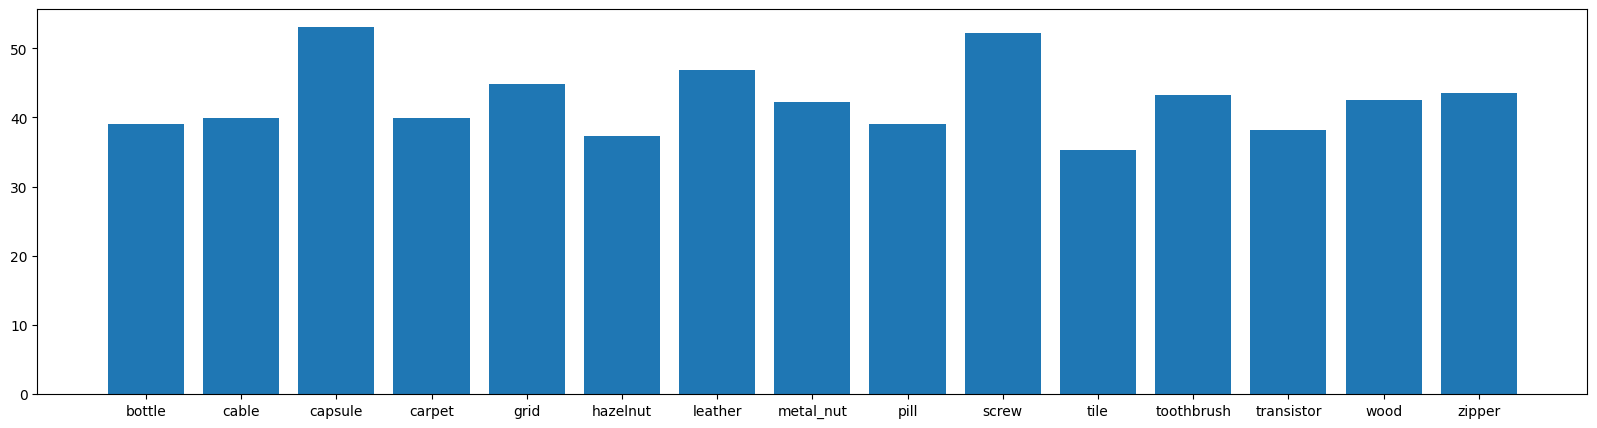

In [165]:
plt.figure(figsize=(20, 5))
plt.bar(objects, psnr_scores_defect_mask)
plt.show()

### SSIM for Defect masks

In [166]:
individual_objects_defect_mask_ssim_scores=[]

In [167]:
model2.eval()
with torch.inference_mode():

    for object in objects:
        ssim_scores=[] #stores the ssim for each image and then finally we can compute the mean from this
        degraded_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val")
        clean_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "GT_clean_image")
        defect_mask_object_image_paths=get_paths_of_an_object(os.getcwd(), object, "Val", "Defect_mask")
        #first we must load the images and then apply appropriate transformations before passing the degraded images to the model
        #finally we can calculate the ssim

        degraded_images=torch.zeros(len(degraded_object_image_paths), 3, 256, 256)
        for i, noisy_image in enumerate(degraded_object_image_paths):
            pil_image=Image.open(noisy_image)
            noisy=transform(pil_image)
            degraded_images[i]=noisy

        #same thing for clean_images
        clean_images=torch.zeros(len(clean_object_image_paths), 3, 256, 256)
        # print("clean images length is ", len(clean_images))
        for i, image in enumerate(clean_object_image_paths):
          # print('i is ', i)
          pil_image=Image.open(image)
          image=transform(pil_image)
          clean_images[i]=image

        reconstructed_images=model2(degraded_images.to(device))

        
        defect_mask_images=torch.zeros(len(defect_mask_object_image_paths), 3, 256, 256)
        for i, image in enumerate(defect_mask_object_image_paths):
            pil_image=Image.open(image)
            defect_mask=transform(pil_image)
            defect_mask_images[i]=defect_mask

        #so we have the defect mask images that we have to apply to each of reconstructed and their correspoding clean images

        for i, image in enumerate(reconstructed_images):
           defect_mask_image=defect_mask_images[i].cpu().numpy()
           
           reconstructed_np_image=image.cpu().numpy()*defect_mask_image
           clean_np_image=clean_images[i].cpu().numpy()*defect_mask_image
           
           ssim_score=compute_ssim(reconstructed_np_image.transpose(1, 2, 0),  clean_np_image.transpose(1, 2, 0))

           ssim_scores.append(ssim_score)
        
        individual_objects_ssim_scores.append(np.mean(ssim_scores))
        print(f"ssim_score for defect mask of {object} is ", np.mean(ssim_scores))

ssim_score for defect mask of bottle is  0.9907153764422482
ssim_score for defect mask of cable is  0.9921377209377387
ssim_score for defect mask of capsule is  0.9996340542438119
ssim_score for defect mask of carpet is  0.9933355962686911
ssim_score for defect mask of grid is  0.9982593457803507
ssim_score for defect mask of hazelnut is  0.9899346978428081
ssim_score for defect mask of leather is  0.9984920779655303
ssim_score for defect mask of metal_nut is  0.9910828656980933
ssim_score for defect mask of pill is  0.9827560057738514
ssim_score for defect mask of screw is  0.9996699000431328
ssim_score for defect mask of tile is  0.9751795040699409
ssim_score for defect mask of toothbrush is  0.9955162384881221
ssim_score for defect mask of transistor is  0.984117042130086
ssim_score for defect mask of wood is  0.9948816486612448
ssim_score for defect mask of zipper is  0.9953856166599213


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (0,).

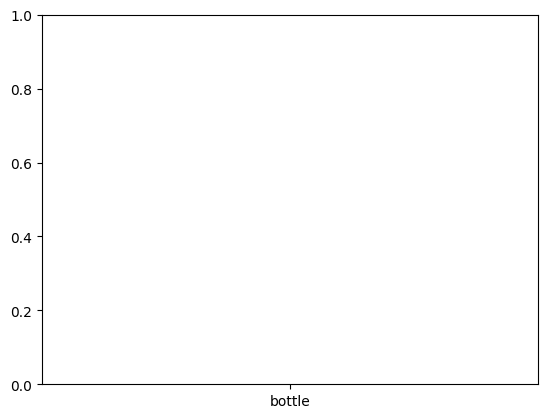

In [168]:
plt.bar(objects, individual_objects_defect_mask_ssim_scores)